# Simulator für Quantenschaltungen

In [39]:
%run ./gates.ipynb

In [40]:
import math

Code ist so gebaut, dass die Mathematik zum Quantencomputing deutlich ersichtlich ist. Ein einzelnes Quantenbit wird als Superpositon der Basisvektoren $|0\rangle$ (`ZERO`) und $|1\rangle$ (`ONE`) beschrieben.

Besonderheit: Mit `np.array` nutzen wir eine Vektorform, die nicht zwischen Spalten- und Zeilenvektoren unterscheidet.

In [41]:
ZERO = np.array([1, 0])
ONE  = np.array([0, 1])

FIFTYFIFTY = 1/math.sqrt(2) * np.array([1, 1])

ID2  = np.array([[1, 0],
                 [0, 1]])
O2   = np.array([[0, 0],
                 [0, 0]])

## Die Mechanik des Quantencomputings: Das Kronecker-Produkt

Das Kronecker-Produkt ist essentiell im Quantencomputing. Es bietet die grundlegende Mechanik an, wie einzelne Quantenbits einerseits einen Quantenzustand initialisieren und wie sich andererseits eine Operation auf Quantenbits im Zustandsraum auswirkt.

Die Methode `kronify` bildet die Systematik in der Nutzung des Kronecker-Produkts ab: Es liegt eine geordnete Zusammenstellung von Qubits vor, deren Anzahl durch `no_of_bits` gegeben ist und die von `0` bis `no_of_bits - 1` durchnummeriert sind. Auf die Qubits werden Operationen angewendet, wobei sich eine Operation auf ein oder mehrere aufeinanderfolgende Qubits erstrecken kann. Dazu sind die Operationen, `operations`, als Dictionary zu übergeben. In dem Dictionary wird die Bitstelle angegeben, ab der die Operation wirkt, und die Operation selber. Zudem ist eine `default_operation` anzugeben, die verwendet wird, wenn es zu einer Bitstelle im Dictionary keine explizite Operation gibt.

In [57]:
def kronify(no_of_bits, operations, default_operation = ZERO):
    result = np.array([1])
    bit = 0
    while (bit < no_of_bits):
        operation = operations.get(bit, default_operation)
        result = np.kron(result, operation)
        bit += int(math.log(operation.shape[0], 2))
    return result

Mit `kronify` kann zum Beispiel der Zustandsvektor initialisiert werden.

In [58]:
kronify(3, {0: ONE}, ZERO)

array([0, 0, 0, 0, 1, 0, 0, 0])

Oder man setzt die Matrizen auf, die auf dem Zustandsvektor operieren wird.

In [59]:
kronify(3, {1: CNOT}, ID2)

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0]])

# Der Zustand eines Quantensystems: `QState`

Der Zustand eines Quantensystem, auch Quantenregisters genannt, ist ein Modellvorstellung, die davon abstrahiert, wo sich die Qubits befinden.

In [45]:
import numpy as np
from cmath import isclose, phase, pi, sqrt
import math
import matplotlib.pyplot as plt
import random

## Initialisierung eines Quantenregisters

* Ein Quantenregister schränkt die Betrachtung auf ausgewählte Qubits ein.
* Die Initialisierung geht von einer gegebenen Anzahl `no_of_bits` "entkoppelter" Qubits aus
* Der initiale Zustand eines jeden Qubits kann durch ein Dictionary (Qubit-Index $\rightarrow$ zweistelliger Qubit-Vektor) angegeben werden
* Der Default-Zustand eines jeden Qubits ist `ZERO`

In [62]:
class QState:
    def __init__(self, no_of_bits, bit_state = {}, default_state = ZERO):
        self.no_of_bits = no_of_bits
        self.state = kronify(no_of_bits, bit_state, default_state)

In [65]:
print(QState(3).state) # Initialisierung: 000 -> 1. Stelle von links
print(QState(3, {0:ONE, 1:ONE}).state) # Initialisierung: 110 -> 6. Stelle von links

[1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0]


## Gültigkeit eines Quantenzustands

Ein Quantenzustand ist gültig, wenn die Summe der Betragsquadrate der Zustandsanteile 1 ergibt.

In [70]:
class QState(QState):
    def isvalid(self):
        return isclose(self.state @ np.conjugate(self.state), 1.0)

## Zwischenspiel: Darstellung eines Quantenregisters

In [71]:
class QState(QState):
    def __repr__(self):
        repr = f"{self.__class__.__name__}({self.no_of_bits}) valid = {self.isvalid()}:"
        for i in range(0, self.state.shape[0]):
            num = self.state[i]
            repr += f"\n{i:2d} |{i:0{self.no_of_bits}b}⟩ "
            repr += f"{num.real if isclose(num.imag, 0.0) else (f'{num.imag}i' if isclose(num.real, 0.0) else f'{num.real} + {num.imag}i')} "
            repr += f"({abs(num):.4f} * e^{phase(num) / pi * 180.0:.2f}°) "
            repr += f"{abs(num * num):.2%}"
        return repr
    
    def show(self):
        print(self)
        return self
    
    def plot(self):
        names = list(map(lambda x: f'|{x}⟩', range(0, self.state.shape[0])))
        values = list(map(lambda x: abs(x), self.state * self.state))
        plt.bar(names, values)
        plt.suptitle(f'{self.__class__.__name__}({self.no_of_bits})')
        plt.show()
        return self

In [72]:
QState(3, {2: ONE})

QState(3) valid = True:
 0 |000⟩ 0 (0.0000 * e^0.00°) 0.00%
 1 |001⟩ 1 (1.0000 * e^0.00°) 100.00%
 2 |010⟩ 0 (0.0000 * e^0.00°) 0.00%
 3 |011⟩ 0 (0.0000 * e^0.00°) 0.00%
 4 |100⟩ 0 (0.0000 * e^0.00°) 0.00%
 5 |101⟩ 0 (0.0000 * e^0.00°) 0.00%
 6 |110⟩ 0 (0.0000 * e^0.00°) 0.00%
 7 |111⟩ 0 (0.0000 * e^0.00°) 0.00%

## Anwendung eines Quantengatters

* Ein Quantengatter ist als Operator, `operator` zu verstehen
* Die Methode `op` setzt die Operation um
* Ein Quantengatter wird durch eine Matrix abgebildet
* Der Operator wirkt auf $n$ Qubits, die Matrix hat entsprechend die Größe $2^n \times 2^n$
* Mit `bit` ist anzugeben, ab welchem Qubit der Operator auf das angegebene Qubit und möglicherweise folgende Qubits wirkt

Wichtig:

* Zu jedem Quantengatter gibt es ein Gatter, mit dem die Berechnung rückgängig gemacht werden kann.
* Mathematisch heißt das: Die Quantengatter werden durch unitäre Matrizen abgebildet
* Physikalisch bedeutet das: Rechnen ohne Energieverlust
* Informationstheoretisch heißt das: Rechnen ohne Mitteilung einer Information

In [74]:
class QState(QState):
    def op(self, operator, bit = 0):
        self.state = kronify(self.no_of_bits, {bit: operator}, ID2) @ self.state
        return self

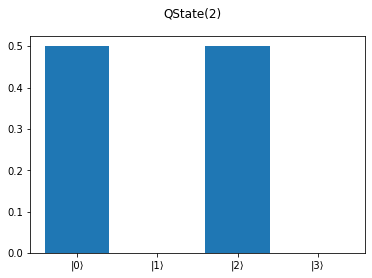

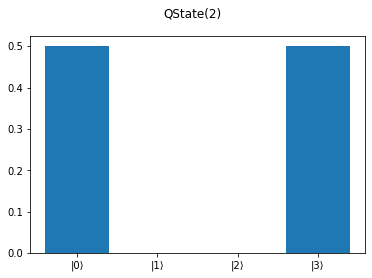

In [80]:
# Beispiel: EPR-Paar
epr = QState(2).op(H).plot().op(CNOT).plot()

## Messvorgang

* Messung ist ein Vorgang, die eine Information aus dem Quantensystem mitteilt und Information im Quantenzustand vernichtet
* Physikalisch: Abgabe von Energie, Teil des 
* Quantensysteme sind probabilistisch

Der Messvorgang wird hier logisch in zwei Anteile `expect` und `collapse` zerlegt.

### Quantenzustand als probabilistischer Erwartungswert

Die Erwartung gibt an, mit welcher Wahrscheinlichkeit ein Qubit bzw. eine Reihe von Qubits an den gegebenen Positionen einen bestimmten Wert annehmen. Bei einem Qubit wird in der Regel die Wahrscheinlichkeit für $|0\rangle$ oder $|1\rangle$ als Erwartung angefragt, bei zwei Qubits eine Kombination aus $|0\rangle\,|0\rangle$, $|0\rangle\,|1\rangle$, $|1\rangle\,|0\rangle$ bzw. $|1\rangle\,|1\rangle$.

In [86]:
class QState(QState):
    def expect(self, query = {0: ZERO}):
        L = kronify(self.no_of_bits, query, ID2)
        return np.sum(L @ (np.conjugate(self.state) * self.state))

In [95]:
# Beispiel
q = QState(2).op(H).show()
print(q.expect({0: ZERO}))
print(q.expect({0: ONE}))
print(q.expect({1: ZERO}))
print(q.expect({1: ONE}))
print(q.expect({0: ZERO, 1: ZERO}))

QState(2) valid = True:
 0 |00⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%
0.4999999999999999
0.4999999999999999
0.9999999999999998
0.0
0.4999999999999999


### Entzug von Information: `collapse`

* `collapse` liefert einen neu instanziierten Quantenzustand zurück

In [96]:
class QState(QState):
    def collapse(self, query = {0: ZERO}):
        L = kronify(self.no_of_bits, query, ID2)
        state = np.sum(L * self.state, axis=0)
        state = (1 / np.linalg.norm(state)) * state
        qstate = QState(self.no_of_bits)
        qstate.state = state
        return qstate

In [100]:
# Funktionsweise
L = kronify(3, {1: ZERO}, ID2)
print(L * np.array([1,2,3,4,5,6,7,8]))
print(np.sum(_, axis=0))

[[1 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0]
 [0 0 0 0 0 6 0 0]]
[1 2 0 0 5 6 0 0]


In [98]:
# Beispiel
q = QState(2).op(H).show()
q.collapse({0: ZERO})

QState(2) valid = True:
 0 |00⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%


QState(2) valid = True:
 0 |00⟩ 1.0 (1.0000 * e^0.00°) 100.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [101]:
# Beispiel
q = QState(2).op(H).show()
q.collapse({0: ONE})

QState(2) valid = True:
 0 |00⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%


QState(2) valid = True:
 0 |00⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 1.0 (1.0000 * e^0.00°) 100.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [102]:
# Beispiel
q = QState(2).op(H).show()
q.collapse({1: ZERO})

QState(2) valid = True:
 0 |00⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%


QState(2) valid = True:
 0 |00⟩ 0.7071067811865476 (0.7071 * e^0.00°) 50.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.7071067811865476 (0.7071 * e^0.00°) 50.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [104]:
# Beispiel: Es ist Unsinn, ein System auf Bit zu kollabieren, dessen Erwartungswert 0 ist.
q = QState(2).op(H).show()
q.collapse({1: ONE})

QState(2) valid = True:
 0 |00⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 3 |11⟩ 0.0 (0.0000 * e^0.00°) 0.00%


/var/folders/0k/rm5kn55j7psf5txx4jbwzvjh0000gn/T/ipykernel_2421/3191954055.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  state = (1 / np.linalg.norm(state)) * state
/var/folders/0k/rm5kn55j7psf5txx4jbwzvjh0000gn/T/ipykernel_2421/3191954055.py:5: RuntimeWarning: invalid value encountered in multiply
  state = (1 / np.linalg.norm(state)) * state


QState(2) valid = False:
 0 |00⟩ nan (nan * e^nan°) nan%
 1 |01⟩ nan (nan * e^nan°) nan%
 2 |10⟩ nan (nan * e^nan°) nan%
 3 |11⟩ nan (nan * e^nan°) nan%

### Die Messung: `measure`

* Messung aus drei logischen Anteilen: Erwartungswert für zu messendes Bit, Zufallsentscheidung (Informationsanteil), Zustandskollaps (Konsequenz der Informationsabgabe)
* Rückgabe der beiden Informationsanteile: Messergebnis und neuer Quantenzustand.
* Neuer Quantenzustand als neue Instanz, damit mit altem Quantenzustand mehrere Messungen durchgeführt werden können.

Verifikation: Nach der Messung muss der Erwartungswert zum Messergebnis 100% betragen.

In [108]:
class QState(QState):  
    def measure(self, bit, this = ONE, that = ZERO):
        expectation = self.expect({bit: this})
        choose = this if random.random() < expectation else that
        return choose, self.collapse({bit: choose})

QState(2) valid = True:
 0 |00⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |11⟩ 0.7071067811865475 (0.7071 * e^0.00°) 50.00%


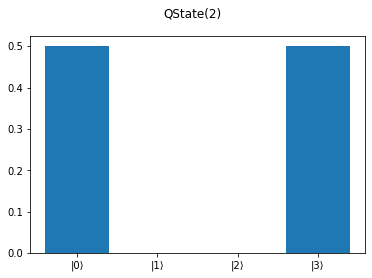

[0 1] 
 QState(2) valid = True:
 0 |00⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |11⟩ 1.0 (1.0000 * e^0.00°) 100.00%
1.0


In [134]:

# Beispiel mehrfach ausführen, um Zufallswahl in Aktion zu sehen
q = QState(2).op(H).op(CNOT).show().plot()
res, q_new = q.measure(0, ZERO, ONE)
print(res, "\n", q_new)
print(q_new.expect({0: res}))

### Sampling

In [191]:
def sampling(n, qstate, bit, this, that):
    _, qstate_new = qstate.measure(bit, this, that)
    for run in range(1, n):
        qstate_new.state = qstate_new.state + qstate.measure(bit, this, that)[1].state
    qstate_new.state = 1.0/n * qstate_new.state
    qstate_new.state = np.sqrt(qstate_new.state)
    return qstate_new
    

In [212]:
sampling(1000, q, 0, ZERO, ONE)

QState(2) valid = True:
 0 |00⟩ 0.705691150575094 (0.7057 * e^0.00°) 49.80%
 1 |01⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |10⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |11⟩ 0.708519583356734 (0.7085 * e^0.00°) 50.20%

# Preliminary Stuff

In [123]:
q = QState(4, {0: np.array([1/sqrt(2), 1/sqrt(2)]),
               1: np.array([1/sqrt(2), 1/sqrt(2)])})
#q = QState(4)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [124]:
q = q.op(PAULIX, 0).op(PAULIX, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [125]:
q = q.op(SWAP, 1).op(CNOT).op(SWAP, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [126]:
q = q.op(CNOT, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
13 |1101⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%


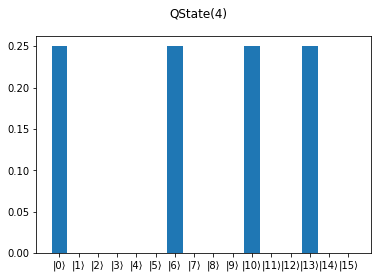

In [127]:
q = q.op(SWAP, 2).op(TOFFOLI).op(SWAP, 2).show().plot()

In [128]:
print(q.expect({2: ZERO, 3: ZERO})) # 25%
print(q.expect({2: ZERO, 3: ONE}))  # 25%
print(q.expect({2: ONE, 3: ZERO}))  # 50%
print(q.expect({2: ONE, 3: ONE}))   #  0%
print(q.expect({2: ZERO})) # 50%
print(q.expect({2: ONE}))  # 50%
print(q.expect({3: ZERO})) # 75%
print(q.expect({3: ONE}))  # 25%

(0.2499999999999999+0j)
(0.2499999999999999+0j)
(0.4999999999999998+0j)
0j
(0.4999999999999998+0j)
(0.4999999999999998+0j)
(0.7499999999999997+0j)
(0.2499999999999999+0j)


Beachte: Aus der Erwartung an die Einzelbits ist nicht so einfach die Erwartung an die Kombination von Bits zu berechnen. Eine Messung verändert den Zustandsvektor, was die zweite Messung beeinflusst. Das ist zwar kommutativ, aber den Erwartungen nicht als Kombination anzusehen.